# Denoising of radio traces

A promising approach for the measurement of ultra-high-energy neutrinos is the detection via their radio emission when interacting in the atmosphere. By connecting many radio antennas, radio arrays are constructed that are supposed to extend over hundreds of square kilometers to obtain sufficient exposure for successfully detecting these rare cosmic messengers. For accurate measurements, the antennas have to be placed in a radio-quiet environment, like Greenland, where the background noise is small. However, the size of the noise can still significantly disturb the measurement.
Therefore, the reduction of this noise in neutrino measurements will be investigated in the following project.

Given are 25000 simulated neutrino signals and realistic background measured at Greenland. In order to achieve an accurate reconstruction, we will try to filter the signals to remove the interfering background.

In [11]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import time
import random
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import matplotlib.ticker as mticker

### Load data from hdf.5 files

In [2]:
f_noise = h5py.File("./noise.hdf5")
f_signal = h5py.File("./simulation.hdf5")

In [3]:
noise = f_noise["traces [mV]"][:]
time_noise = f_noise["times [ns]"][:]

signal = f_signal["traces [mV]"][:]
time_signal = f_signal["times [ns]"][:]

In [4]:
s = signal.copy()
s = s.flatten()
print(s[0]+0.095_642_772_558_213_45)
print(np.min(np.abs(s)))

0.0
3.641352276330363e-10


Check for digistep

In [5]:
#s = signal.copy()
#s = s.flatten()
#all_signal = np.unique(s)
#print(len(all_signal), len(s))
# same length --> no same values --> no digitisation (floats from simulation)

n = noise.copy()
n = n.flatten()
unique_noise = np.unique(n)
print(len(unique_noise), len(n))
print(unique_noise)
#print(unique_noise[1:]-unique_noise[:-1])


128 52428800
[-39.05325444 -34.31952663 -33.72781065 -32.5443787  -31.95266272
 -31.36094675 -30.76923077 -30.17751479 -29.58579882 -28.99408284
 -28.40236686 -27.81065089 -27.21893491 -26.62721893 -26.03550296
 -25.44378698 -24.85207101 -24.26035503 -23.66863905 -23.07692308
 -22.4852071  -21.89349112 -21.30177515 -20.71005917 -20.1183432
 -19.52662722 -18.93491124 -18.34319527 -17.75147929 -17.15976331
 -16.56804734 -15.97633136 -15.38461538 -14.79289941 -14.20118343
 -13.60946746 -13.01775148 -12.4260355  -11.83431953 -11.24260355
 -10.65088757 -10.0591716   -9.46745562  -8.87573964  -8.28402367
  -7.69230769  -7.10059172  -6.50887574  -5.91715976  -5.32544379
  -4.73372781  -4.14201183  -3.55029586  -2.95857988  -2.36686391
  -1.77514793  -1.18343195  -0.59171598   0.           0.59171598
   1.18343195   1.77514793   2.36686391   2.95857988   3.55029586
   4.14201183   4.73372781   5.32544379   5.91715976   6.50887574
   7.10059172   7.69230769   8.28402367   8.87573964   9.4674556

Digitalisation of signal

In [6]:
digstep = 0.59171598
s_new = signal.copy()
s_dig = np.round(s_new/digstep)*digstep

s_d = s_dig.copy()
s_d = s_d.flatten()
all_signal_d = np.unique(s_d)
print(len(all_signal_d), len(s_d))
times = np.linspace(0, 640, 2048)

# signal_old = signal.copy()
# signal = s_dig.copy()
# print(signal.shape)


7377 52428800


### Plot example traces

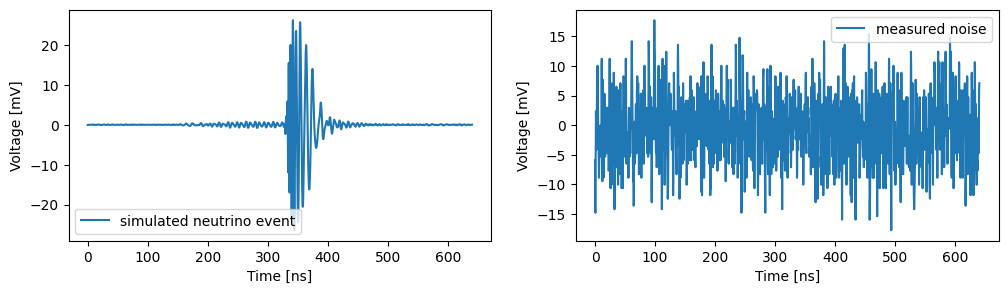

In [38]:
idx = 2

plt.figure(1, (12, 3))
plt.subplot(1, 2, 1)
plt.plot(times, signal[idx], label="simulated neutrino event")
#plt.plot(times, noise[idx] + signal[idx], label="measurement", c="b")
#plt.plot(times, signal[idx], c="r", label="simulation")
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [ns]")
#plt.title("Neutrino event")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(times, noise[idx] ,label="measured noise")
#plt.plot(times, noise[idx] + s_dig[idx], c="b", label="noise")
#plt.plot(times, s_dig[idx], c="r", label="signal_digitized")
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [ns]")
#plt.title("Background event")
plt.legend()
plt.savefig('Data_example.pdf',bbox_inches='tight')
plt.show()


To create the measurement of the detector, simply the sum of the recorded noise is added to the simulated neutrino signal.

In [7]:
measurement = signal + noise

In [8]:
signal.shape

(25600, 2048)

# Statistik des Noises

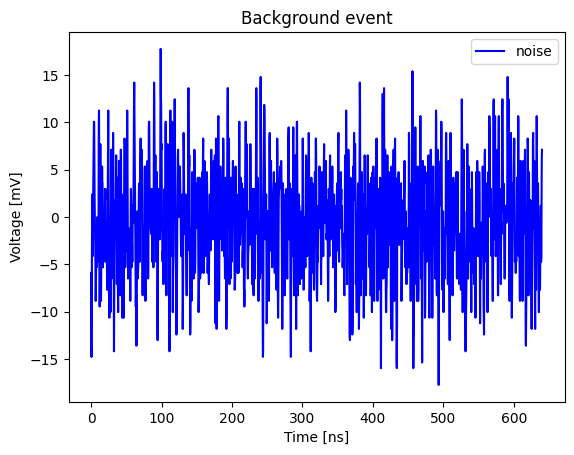

In [9]:
plt.figure()
plt.plot(times, noise[idx], c="b", label="noise")
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [ns]")
plt.title("Background event")
plt.legend()
plt.show()

# Stats for every point in time

In [10]:
interval = 1e-6
n, bins = np.histogram(noise[:, 1200], bins=np.arange(-30+interval/2, 30-interval/2, interval))
noise_values = bins[:-1][n != 0]
df_noise_values = noise_values[1:]-noise_values[:-1]
# print(df_noise_values)
print(np.mean(df_noise_values[7:-7]), np.std(df_noise_values[7:-7]))


0.5917159732109979 1.6323801810721244e-07


In [22]:
def filter_hist(n, bins):
    X = bins[:-1]+(bins[1]-bins[0])/2
    return X[n > 0], n[n > 0]


def gauss(x, sigma, mu, a):
    return (a/(np.sqrt(2*np.pi)*sigma))*np.exp(-0.5*((x-mu)/sigma)**2)

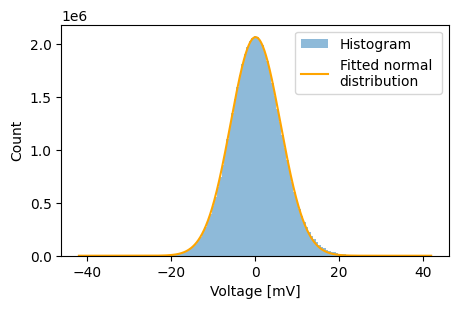

In [32]:
interval = 0.59171598
noise = noise.flatten()
plt.figure(figsize=(5,3))
n, bins, _ = plt.hist(noise, bins=np.arange(-70.5*interval, 70*interval, interval), alpha=0.5,label='Histogram')
xx, yy = filter_hist(n, bins)
#print(bins)


popt, pcov = curve_fit(gauss, xx, yy, p0=[10, 0, 1000])
XX = np.linspace(-42, 42, 10000)

plt.plot(XX, gauss(XX, *popt), c='orange',label='Fitted normal \ndistribution')
plt.xlabel('Voltage [mV]')
plt.ylabel('Count')
plt.legend(loc ='upper right')
# plt.plot(xx,yy,'o',ms=2,c='g')
#print(np.max(noise),np.min(noise))
#print(popt,np.diag(np.sqrt(np.abs(pcov))))
plt.savefig('plots/NoiseHist.pdf',bbox_inches = 'tight')
plt.show()

In [51]:
mean_std = np.empty((2048, 4))
for counter, timepoint, in enumerate(noise.T):
    interval = 0.6
    n, bins = np.histogram(timepoint, bins=np.arange(-30+interval/2, 30-interval/2, interval))
    xx, yy = filter_hist(n, bins)
    popt, pcov = curve_fit(gauss, xx, yy, p0=[10, 0, 1000])

    mean_std[counter] = popt[1], np.sqrt(pcov[1, 1]), popt[0], np.sqrt(pcov[0, 0])  # mean,mean_err,sigma,sigma_err

mean_std = mean_std.T
print(pcov)

[[1.35185581e-03 2.89179561e-08 1.66598705e+00]
 [2.89179561e-08 1.35174326e-03 3.84082843e-05]
 [1.66598705e+00 3.84082843e-05 6.15891219e+03]]


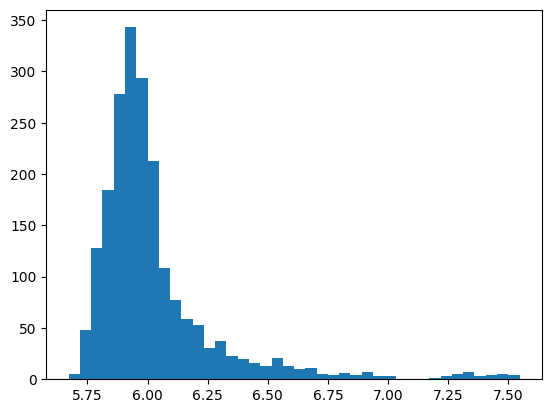

In [14]:
n, b, _ = plt.hist(mean_std[2], bins=40)


In [15]:
for i in range(4):
    print(np.mean(mean_std[i]))

0.12749031725229984
0.0381481903793948
6.030199172727581
0.03814917202328856


In [52]:
def sigma_interval(mean, mean_err, sigma, sigma_err, order, sign):
    if sign == 0:
        vp, ep = sigma_interval(mean, mean_err, sigma, sigma_err, order, 1)
        vn, en = sigma_interval(mean, mean_err, sigma, sigma_err, order, -1)
        return vp, ep, vn, en
    else:
        value = mean + sign*order*sigma
        err = np.sqrt(mean_err**2+(sign*order*sigma_err)**2)
        return value, err


In [31]:
p3, p3e, n3, n3e = sigma_interval(*mean_std, 3, 0)
new_var1 = np.concatenate( [p3,n3])
new_var = np.abs(new_var1)
np.mean(new_var)

18.090597518182744

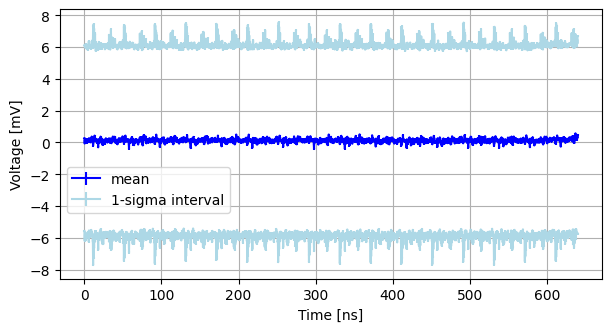

In [61]:
p1, p1e, n1, n1e = sigma_interval(*mean_std, 1, 0)
plt.figure(figsize=(7,3.5))
plt.errorbar(times, mean_std[0], yerr=mean_std[1], c='blue',label='mean')
plt.errorbar(times, p1, yerr=p1e, c='lightblue',label = '1-sigma interval')
plt.errorbar(times, n1, yerr=n1e, c='lightblue')
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [ns]')
plt.legend(loc = 'center left',bbox_to_anchor=(0,0.33))
# plt.xlim((0,40))
plt.grid()
plt.savefig('noise_meanstd.pdf',bbox_inches = 'tight')
plt.show()


#mean and std for every trace

In [62]:
trace_mean_std = np.empty((25600, 2))
for counter, trace in enumerate(noise):
    trace_mean_std[counter, 0] = np.mean(trace)
    trace_mean_std[counter, 1] = np.std(trace)
trace_mean_std = trace_mean_std.T


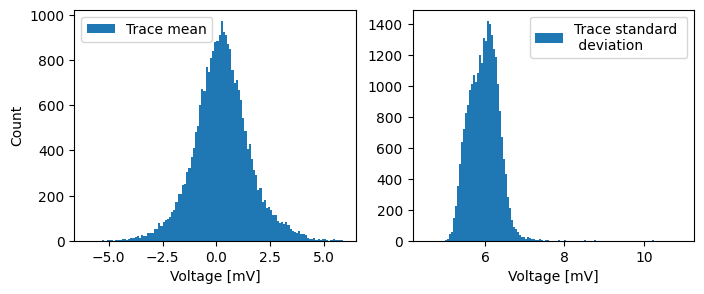

mean, median,std of means 0.24981274125138683 0.2360507581360946 1.2943358738600468


In [66]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
ax0.hist(trace_mean_std[0], bins=np.arange(-6, 6, 0.1),label = 'Trace mean')
ax0.legend()
ax1.hist(trace_mean_std[1], bins=np.arange(4.5, 11, 0.05),label = 'Trace standard \n deviation')
ax1.legend()

ax0.set_ylabel('Count')
ax0.set_xlabel('Voltage [mV]')
ax1.set_xlabel('Voltage [mV]')
plt.savefig('Tracestats.pdf',bbox_inches = 'tight')
plt.show()
print('mean, median,std of means', np.mean(trace_mean_std[0]), np.median(
    trace_mean_std[0]), np.std(trace_mean_std[0]))

# Signal

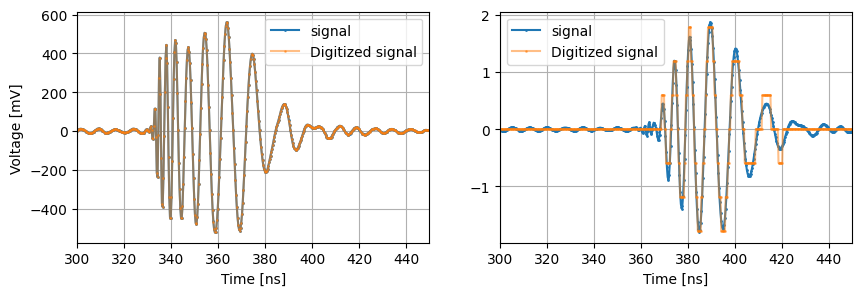

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i ,ax in zip([6200,200],axes):#range(200, 12200, 2000):
   
    ax.set_xlabel("Time [ns]")

    ax.plot(times, signal[i], 'o-', ms=1, label="signal")
    ax.plot(times, s_dig[i], 'o-', ms=1,
             alpha=0.5, label="Digitized signal")
    ax.grid()
    ax.set_xlim(300., 450.)
    ax.legend()
axes[0].set_ylabel("Voltage [mV]")
plt.savefig('SignalDigi.pdf',bbox_inches='tight')
plt.show()

560.4682334169403 206.1847405037695
[-238.74216912  378.30609021 -392.3692058   443.53683055 -447.14178791
  467.76606038 -447.82115711  432.51530827 -480.42269206  505.66019151
 -521.96560145  560.46823342 -514.10607046  398.21633324 -211.15864694]
1.865527305079502 0.686289142482714
[-0.88735022  1.19341181 -1.38837198  1.61196389 -1.80060068  1.86552731
 -1.74248828  1.40598487 -0.82763061]


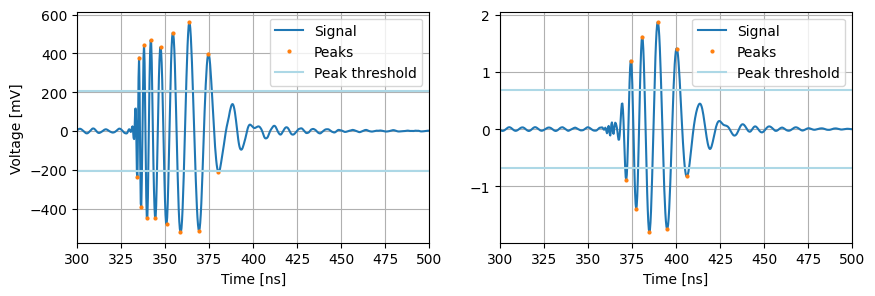

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i ,ax in zip([6200,200],axes):#range(200, 12200, 2000):
    cur_sig = signal[i]
    s_max, s_max_i = np.max(cur_sig), np.argmax(cur_sig)
    print(s_max,s_max/np.e)
    peak_i, _ = find_peaks(np.abs(cur_sig), height=s_max/np.e)
    peaks = cur_sig[peak_i]
    print(peaks)


    ax.plot(times, signal[i], label="Signal")
    ax.plot(times[peak_i], peaks, 'o', ms=2,label='Peaks')
    ax.axhline(y = s_max/np.e,c='lightblue',label = 'Peak threshold')
    
    ax.axhline(y = -s_max/np.e,c='lightblue')
    
    ax.set_xlabel("Time [ns]")
    ax0.grid()

    ax.grid()
    ax.set_xlim(300., 500.)
    ax.legend()
axes[0].set_ylabel("Voltage [mV]")
plt.savefig('Peakfindexp.pdf',bbox_inches = 'tight')
plt.show()

In [8]:
signal_stats = np.empty((25600, 5))
for counter, cur_sig in enumerate(signal):
    s_max, s_max_i = np.max(cur_sig), np.argmax(cur_sig)
    peak_i, _ = find_peaks(np.abs(cur_sig), height=1/np.e * s_max)
    peak_times = times[peak_i]
    signal_stats[counter] = s_max, times[s_max_i], peak_times[0], peak_times[-1] - peak_times[0], len(peak_i)  # strength(max),center,beginning,duration,peak_count
signal_stats = signal_stats.T


In [9]:
print(max(signal_stats[4]), np.min(signal_stats[4]))
print(np.median(signal_stats[0]))
print((np.argmin(np.abs(np.sort(signal_stats[0])-0.59171598/2))))
print(np.argmin(np.abs(np.sort(signal_stats[0])-5.94))/25600)


19.0 6.0
28.50809822377045
324
0.3097265625


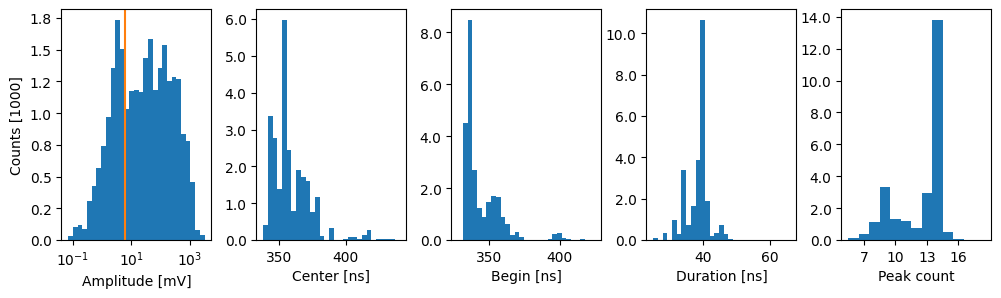

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.subplots_adjust(wspace=0.3)
(ax0, ax1, ax2, ax3, ax4) = axes

ax0.hist(signal_stats[0], bins=np.logspace(np.log10(np.min(signal_stats[0])), np.log10(np.max(signal_stats[0])),30))
for i in range(1,4):
    axes[i].hist(signal_stats[i], bins=np.linspace(np.min(signal_stats[i]), np.max(signal_stats[i]),30))
# ax1.hist(signal_stats[1], np.arange(335, 445, 2.5))
# ax2.hist(signal_stats[2], np.arange(325, 425, 2.5))
# ax3.hist(signal_stats[3], np.arange(20, 70, 2.5))

ax4.hist(signal_stats[4], np.arange(5.5, 19.5))


ax0.set_xscale('log')
ax0.set_xticks([0.1,10,1000])
ax0.axvline(x = 5.94,c='C1')
ax4.set_xticks([7,10,13,16])
ax0.set_ylabel('Counts [1000]')
for ax, xlabe in zip(axes, ['Amplitude [mV]', 'Center [ns]', 'Begin [ns]', 'Duration [ns]', 'Peak count']):
    #ax.set_yscale('log')
    ax.set_xlabel(xlabe)
    y_vals = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_vals))
    

    ax.set_yticklabels(['{:1.1f}'.format(x /1000) for x in y_vals])
#plt.savefig('SignalStats.pdf',bbox_inches='tight')
plt.show()
